In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
descriptor = cv2.SIFT_create()
def get_keypoints_and_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return descriptor.detectAndCompute(gray, None)

In [4]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
def match_with_bruteforce(features1, features2):
    matches = matcher.match(features1,features2)
    matches = sorted(matches, key = lambda x:x.distance)
    return matches

In [5]:
def compute_homography(kps1, kps2, matches):
    ptsA = np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2) 
    ptsB = np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2) 
    
    return cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 5.0)

In [6]:
def overlay_images(source, overlay):
    alpha = cv2.cvtColor(overlay, cv2.COLOR_RGB2GRAY)[:,:] > 0
    mask = np.dstack((alpha, alpha, alpha))

    h, w = overlay.shape[:2]
    source[0:h, 0:w] = (overlay * mask) + (source[0:h, 0:w] * ~mask)

    return source

In [7]:
def crop_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = [cv2.boundingRect(contour) for contour in contours]
    x, y, w, h = max(cnts, key=lambda c: c[2] * c[3])
    return image[y:y+h, x:x+w]

In [8]:
def create_panorama(images):
    if(len(images) == 1):
        return images[0]

    keypoints, features = zip(*[get_keypoints_and_features(image) for image in images])
    matches = [match_with_bruteforce(features[i], features[i+1]) for i in range(len(images)-1)]
    homographies, statuses = zip(*[compute_homography(keypoints[i], keypoints[i+1], matches[i]) for i in range(len(images)-1)])

    panorama = images[0]
    for i in range(1,len(images)):
        width = panorama.shape[1] + images[i].shape[1]
        height = panorama.shape[0] + images[i].shape[0]

        transformed = images[i]
        for h in range(i-1, -1, -1):
            transformed = cv2.warpPerspective(transformed, homographies[h], (width, height))
            
        panorama = crop_border(overlay_images(transformed, panorama))

    return cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR) #plt usa BGR

In [9]:
def show_result(panorama, img1, img2, img3):
    fig = plt.figure()
    gs = fig.add_gridspec(2,3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, :])

    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
    ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_RGB2BGR))
    ax4.imshow(panorama)

    ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off')
    plt.show()

### IC - UFAL

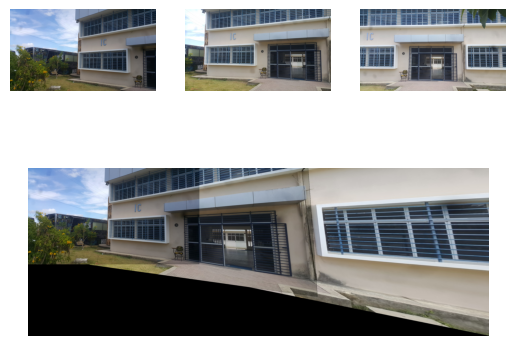

In [10]:
ic_images = [cv2.imread(f'images/IC/{i}.jpg') for i in range(1,3+1)]
ic = create_panorama(ic_images)
show_result(ic, *ic_images)

### Predio

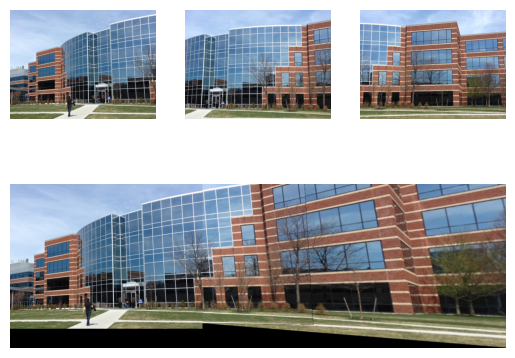

In [11]:
predio_images = [cv2.imread(f'images/Predio/{i}.jpg') for i in range(1,3+1)]
predio = create_panorama(predio_images)
show_result(predio, *predio_images)

### Rua

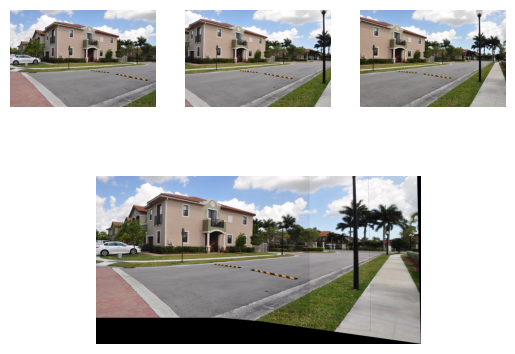

In [12]:
rua_images = [cv2.imread(f'images/Rua/{i}.jpg') for i in range(1,3+1)]
rua = create_panorama(rua_images)
show_result(rua, *rua_images)

### Londres

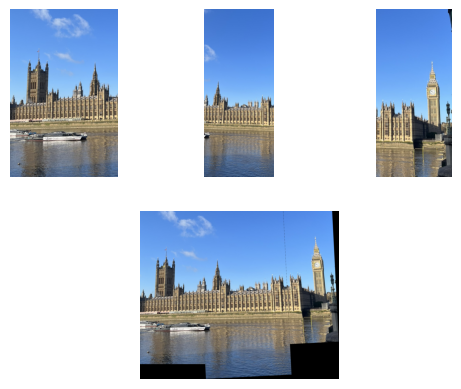

In [13]:
londres_images = [cv2.imread(f'images/Londres/{i}.jpg') for i in range(1,3+1)]
londres = create_panorama(londres_images)
show_result(londres, *londres_images)

### Taj Mahal

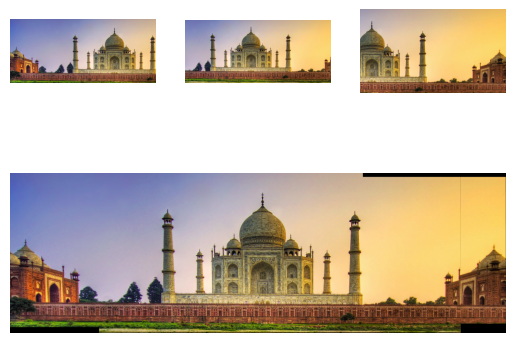

In [16]:
taj_images = [cv2.imread(f'images/TajMahal/{i}.png') for i in range(1,3+1)]
taj = create_panorama(taj_images)
show_result(taj, *taj_images)